(CellCycling_Loading)=
# Basic file loading operations

The core of all the data-loading operations is the `FileManager` class defined in the `read_input` submodule. The `FileManager` class can load both `.DTA` and `.mpt` files generated respectively by the GAMRY and BIOLOGIC potentiostats. The class provides a simple interface to automatically parse all the loaded data and hold them in memory in the form of bytestreams. To show how this object can be operated let us consider the case of a `.mpt` file that, for the purposes of this example, is provided in the documentation folder. Let us look at the content of such file:

In [1]:
with open("./example.mpt", 'r') as file:
    for line in file:
        print(line.rstrip('\n'))

...
Acquisition started on : 25/12/2022 13:00:00
...
Number of loops : 2
Loop 0 from point number 0 to 5
Loop 1 from point number 6 to 11

mode	ox/red	error	control changes	time/s	control/V/mA	Ewe/V	I/mA	dq/mA.h	(Q-Qo)/mA.h	Q charge/discharge/mA.h	Ece/V	P/W	Q discharge/mA.h	Q charge/mA.h	Capacity/mA.h	control/V	control/mA	Ewe-Ece/V	
1	1	0	1	1,000000000000000E+002	8,0000000E+002	1,0000000E+000	8,0000000E+002	4,000000000000000E+000	1,100000000000000E+003	1,100000000000000E+003	3,0000000E-006	1,0000000E+000	0,000000000000000E+000	1,000000000000000E+003	1,000000000000000E+003	0,0000000E+000	8,0000000E+002	1,0000000E+000
1	1	0	1	1,010000000000000E+002	8,0000000E+002	1,1000000E+000	8,0000000E+002	4,000000000000000E+000	1,100000000000000E+003	1,100000000000000E+003	3,0000000E-006	1,0000000E+000	0,000000000000000E+000	1,000000000000000E+003	1,000000000000000E+003	0,0000000E+000	8,0000000E+002	1,0000000E+000
1	1	0	1	1,020000000000000E+002	8,0000000E+002	1,2000000E+000	8,0000000E+002	4,000000000

As it can be seen, the provided file describes: two full charge/discharge cycles, each of wich composed by two halfcycle, each of which composed by 3 time-steps.

To load this `.mpt` file using the `FileManager` class, the following procedure can be used:

In [2]:
# Loading the FileManager class from the cellcycling.read_input module
from echemsuite.cellcycling.read_input import FileManager

# Creating an instance of the FileManager class
manager = FileManager(verbose=False)

# Loading all the .mpt file in the current folder
manager.fetch_from_folder("./", extension=".mpt")   

After the call to the `fetch_from_folder` function, all the data has been loaded in the class and parsed in single independent half-cycles. 

:::{admonition} Loading files manually
Please notice how the user can also manually specify a list of files to be loaded by using the function `fetch_files` according to the syntax:

```
manager = FileManager()
manager.fetch_files(["./example.mpt"]) 
```

Please notice how in this case the file extension is automatically detected from the filenames contained in the list. As such the extension must be available and omogeneous between the various files in the list.
:::

Considering that in the previous example we have loaded a single `.mpt` file, the half-cycle ordering is unambiguos and the parsed data can immediately be converted into the corresponding `Cycle` and `CellCycling` objects by using the built-in `get_cycles` and `get_cellcycling` class methods:

In [3]:
# Obtain the cellcycling object from the manager
cellcycling = manager.get_cellcycling()
print(cellcycling)

# Obtain the list of cycle objects from the manager
cycle_list = manager.get_cycles()
print(cycle_list[0])

If the cell-cycling data is instead loaded from a set of `.DTA` files, either complete or partial, the ordering of the half-cycles is not strictly encoded by the data available to the `FileManager` and, as such, user intervention may be needed. The `FileManager` will try to automatically generate a suggested ordering of the half-cycle files based on their timestamp and type. The suggested ordering can be obtained by calling the memeber function `suggest_ordering` that will return a list of lists containing the name of the loaded files. Each list-type entry represents a half-cycle level; lists with more than one element will represent partial half-cycle files to be merged. As an example consider the followiing list:

```
[["Charge_1.DTA"], ["Charge_2.DTA", "Charge_2b.DTA"], ["Charge_3.DTA"]]
```

this list represents an ordering that will generate 3 half-cycles in which the middle one will be generated from the merging of `Charge_2.DTA` and `Charge_2b.DTA`. The user can either accept the automatically generated ordering or can manually specify its own. The selected ordering can then be applyed by passing it explicitly to the `get_cycles` and `get_cellcycling` functions as the keyworded argument `custom_order`.

To better show how this can be done, let us consider the following example in which two partial `.DTA` halfcycle charge files are provided, together with a complete discharge halfcycle file, to the file-manager.

Available files: charge_1.DTA, discharge_1.DTA, charge_1b.DTA

Loaded halfcycles datasets:
2022-07-23 20:25:33: (charge) charge_1.DTA
2022-07-24 00:23:03: (discharge) discharge_1.DTA
2022-07-23 20:28:33: (charge) charge_1b.DTA

Ordering suggested by the FileManager object:
[['charge_1.DTA', 'charge_1b.DTA'], ['discharge_1.DTA']]


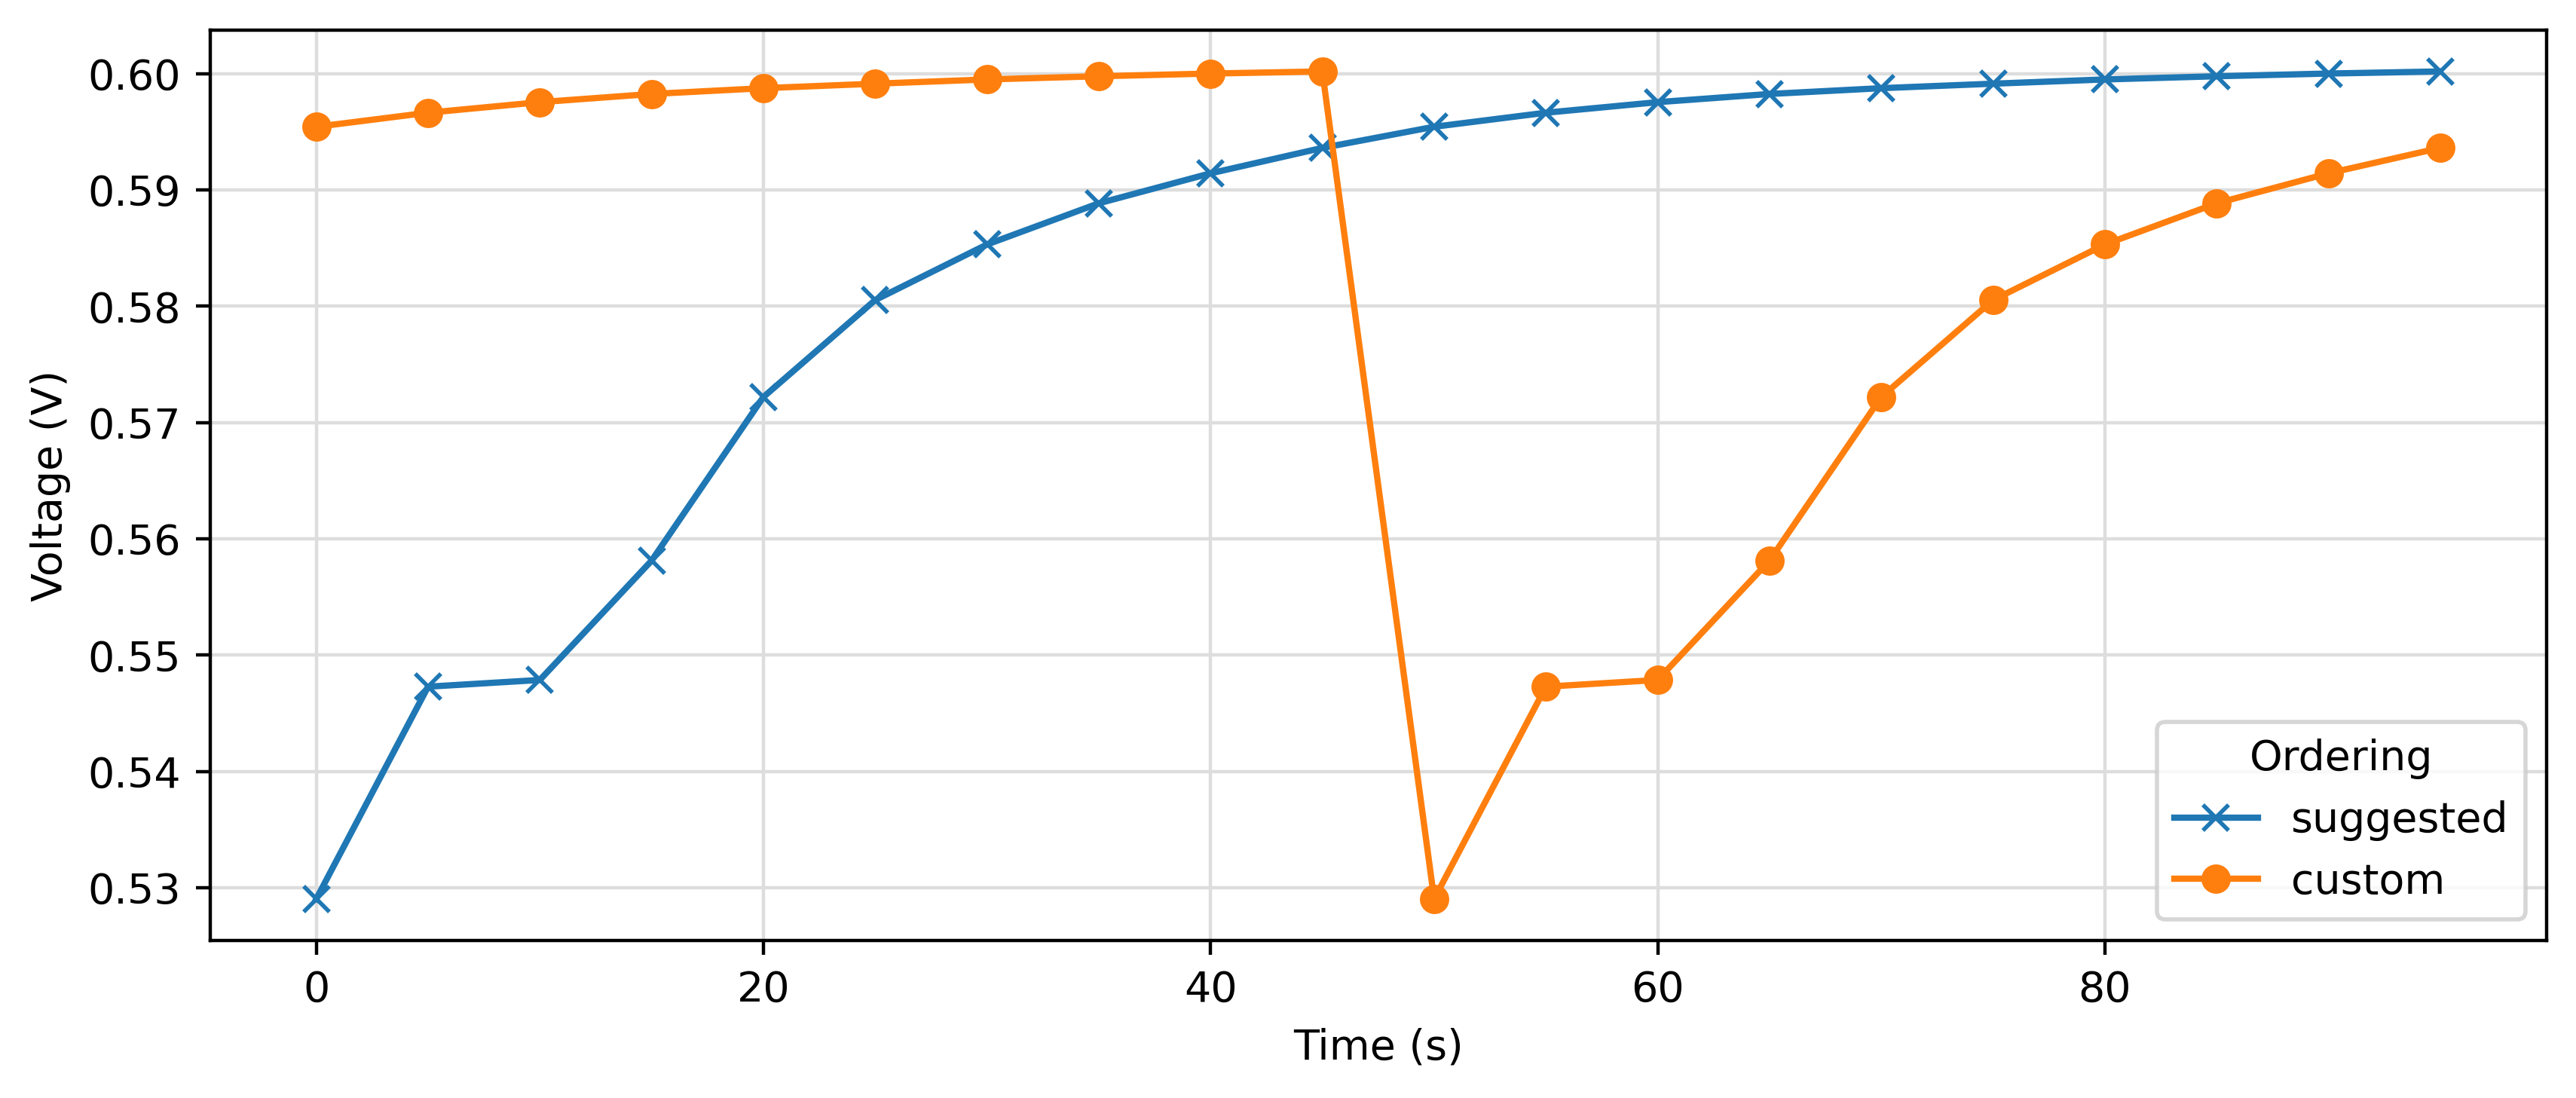

In [10]:
import os
import matplotlib.pyplot as plt
from echemsuite.cellcycling.read_input import FileManager
from echemsuite.cellcycling.cycles import Cycle

# Define the path to the folder holding the files
folder = "./example_partial_DTA"

# Print a list of the available files
print(f"Available files: {', '.join([f for f in os.listdir(folder)])}\n")

# Load and parse the .DTA files contained in the "my_folder" directory
manager = FileManager()
manager.fetch_from_folder(folder, ".DTA")

# Print a list of the loaded halfcycles
print("Loaded halfcycles datasets:")
for name, obj in manager.halfcycles.items():
    print(f"{obj.timestamp}: ({obj.halfcycle_type}) {name}")
print("")

# Print the suggested ordering of the loaded-halfcycles
print("Ordering suggested by the FileManager object:")
print(manager.suggest_ordering())

# Plotting the result obtained by concatenating the data according to the suggested ordering
# and according to a user-specified ordering

suggested = manager.get_cellcycling()
custom = manager.get_cellcycling(custom_order=[['charge_1b.DTA', 'charge_1.DTA'], ['discharge_1.DTA']] )

fig = plt.figure(figsize=(10, 4), dpi=400)

plt.plot(suggested[0].charge.time, suggested[0].charge.voltage, label="suggested", marker="x")
plt.plot(custom[0].charge.time, custom[0].charge.voltage, label="custom", marker="o")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid(which="major", c="#DDDDDD")
plt.legend(title="Ordering")

## Loading data from a BytesIO bytestream

The `read_input` sub-module has been developed to also operate in a web-application environment minimizing the I/O calls done on local copies of the loaded files. For this reason, all the loaded files are immediately converted into binary bytestreams and saved in a `bytestrem` dictionary saved in memory. By taking advantage of this behavior, a parametrized `FileManager` object can also be generated by directly setting the `bytestream` buffer via the provided setter.

To show how this can be done let us, first of all, define a `BytesIO` version of the `.mpt` file considered before. This can easily be done with few lines of code:

In [5]:
# Load the BytesIO stream object from the io module
from io import BytesIO

# Open the file and load it as a bytes stream
my_bytestream = None
with open("./example.mpt", 'rb') as binary_file:
    my_bytestream = BytesIO(binary_file.read())

The loaded stream can now be used to directly initialize the `FileManager` class according to:

In [6]:
from echemsuite.cellcycling.read_input import Instrument

# Create a FileManager instance
manager = FileManager()

# Set the bytestream dictionary using the loaded data
manager.bytestreams = {"example.mpt" : my_bytestream}
manager._instrument = Instrument.BIOLOGIC

# Call the parse function
manager.parse()

Please observe how the `FileManager` class has no access to the file extension (the label provided here as a dictionary key was used only for clarity) and, as a direct consequence, does not know the instrument type. This requires the user to manually set the `_instrument` variable. Furthermore, unlike the previous example in which the call to the `parse` function was avoided thanks to the `autoparse` mode of the `fetch_from_folder` function, this time the call to the `parse` function must be made explicitly. 